### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.ticker as mticker

from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift
import data_UniBremen.SIC as unisic

## Function to run pease model

In [791]:
def Pease_Model_v2(event_df, wf=0.02, ta=35, poly_dir=145, Hi = 25 * units('cm'), show_plot = False):


    def convert_to_k(T):

        if T.units == 'degree_Celsius':
            T = T.to('degree_Kelvin')
        elif T.units == 'delta_degree_Celsius':
            print('T!! should not be delta deg C')
        return T


    def find_Qlu(Tw, sigma, eo):
        Tw = convert_to_k(Tw)
        qlu = sigma * eo * Tw**4
        return qlu.to('W/m2')


    def find_Qld(Ta, sigma, ea):
        Ta = convert_to_k(Ta)
        qld = sigma * ea * Ta**4
        return qld.to('W/m2')


    def find_Qs(Ta, Tw, rho_a, Cpa, Va):

        Ta = Ta.magnitude * units('delta_degree_Celsius')
        Tw = Tw.magnitude * units('delta_degree_Celsius')

        Ch = 2e-3 # sensible heat coefficient

        qs = rho_a * Ch * Cpa * Va * (Ta-Tw)

        return qs.to('W/m2')


    def open_Qld(event_df):
        # determine event year to open
        event_year = pd.to_datetime(event_df.time.values[-1]).year
        if pd.to_datetime(event_df.time.values[-1]).month == 12:
            event_year+=1

        # grab shortwave downward data
        with xr.open_dataset(f'../data/forcing/regional_daily_era_strd_{event_year}_v7.nc') as ds_sw:
            down_longwave = ds_sw.strd.sel(time=event_df.time.values).values * units('W/m2')

        qld = (down_longwave) # longwave down

        return qld
    
    
    def open_Qr(event_df):
        # determine event year to open
        event_year = pd.to_datetime(event_df.time.values[-1]).year
        if pd.to_datetime(event_df.time.values[-1]).month == 12:
            event_year+=1

        # grab shortwave downward data
        with xr.open_dataset(f'../data/forcing/regional_daily_era_ssrd_{event_year}_v7.nc') as ds_sw:
            down_shortwave = ds_sw.ssrd.sel(time=event_df.time.values).values * units('W/m2')

        qr = (1-0.1)*(down_shortwave) # short wave radiation absorbed (10% albedo)

        return qr
    
    
    
    # wind component that extends polynya
    wind_angle = (poly_dir+ta)*units('degree')
    wind_comp = vectors.comp_along_theta(event_df['u10'].values, event_df['v10'].values, wind_angle)
    wind_speed = np.sqrt(event_df['u10'].values**2 + event_df['v10'].values**2) * units('m/s')

    # daily ice drift
    Vi = wf * wind_comp*units('m/s').to('km/day')

    # air temperature
    Ta = event_df['t2m'].values * units('degC')

    # water temperature
    Tw = -1.8 * units('degC')

    # surface heat balance
    #-----------------------
    # define positive upward
    Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
#     Qld = -open_Qld(event_df)
    Qs = -find_Qs(Ta, Tw, cst['rho_a'], cst['Cp_a'], wind_speed)
    Qr = -open_Qr(event_df) # short wave radiation absorbed (5% albedo)

    Qnet = Qlu+Qld+Qs+Qr

    # heat flux to ice production rate
    #-----------------------------------
    Fi = (Qnet / (cst['L_i']*cst['rho_i'])).to('cm/day')
    
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(3,3))
        ax.plot(Qs, label='sensible')
        ax.axhline(Qlu, label='lw u', c='b')
        ax.plot(Qld, label='lw d')
        ax.plot(Qr, label='shortwave')
        ax.plot(Qnet, c='k', label='net')
        ax.legend()
        
        
        
    # iteratively solve for the length
    #---------------------------------
    Xp = np.array([0]) * units('m')

    for tt in range(len(event_df)):

        # current length
        X_curr = Xp[-1]

        # change in length
        dXdt = Vi[tt] - X_curr * Fi[tt] / Hi
        dX = dXdt * units('day')


        Xnew = X_curr + dX
        Xp = np.append(Xp, Xnew)


    X_num = Xp[1:].to('km')

    # solve for limiting width
    #---------------------------------
    X_max = (Vi * Hi / Fi).to('km')
    # time to reach 95% of limiting size
    t95 = (3 * Hi / Fi).to('day')
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(8,3))
        ax.plot(event_df.time, np.cumsum(Vi.magnitude), marker='.', c='k', label='Fi=0')
        ax.plot(event_df.time, X_num.to('km'), label='iter')
        ax.plot(event_df.time, X_max.to('km'), label='limiting width')
        ax.bar(event_df.time, event_df.length_145max, color='lightgray', label='obs')
        plt.legend()

    X_zip = np.cumsum(Vi*units('day'))
    
    return X_num, X_max, t95, X_zip, Ta, Vi, wind_speed

In [792]:
# constants
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

# polynya and regional stats

In [793]:
df = pd.read_csv('../data/compiled_stats.csv')

df['esei'] = vectors.comp_along_theta(df['ui'], df['vi'], 145*units('degree')) * units('cm/s').to('km/day')
df['ese10'] = 0.02*vectors.comp_along_theta(df['u10'], df['v10'], 180*units('degree'))* units('m/s').to('km/day')
# df['ese10'][df.year>=2016] = 1.3*df['ese10'][df.year>=2016]




df['si_km'] = df['si'] * units('cm/s').to('km/day')

df['e10'] = - df['u10']
# manually modify this for now since I set too strict of threshold

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    df[f'{cat}_r'] = 90-df[f'{cat}']
    df[f'{cat}_r'][df[f'{cat}_r']<0]+=360

df['up'] = df['centermass_length'].values * np.cos(df['centermass_direction'].values*np.pi/180)
df['vp'] = df['centermass_length'].values * np.sin(df['centermass_direction'].values*np.pi/180)
                     
    
vi = (df['ui'].values, df['vi'].values)
vw = (df['u10'].values, df['v10'].values)
vp = (df['up'].values, df['vp'].values )
                              
df['ta_wi'] = vectors.turning_angle(vw,vi).magnitude
df['ta_ip'] = vectors.turning_angle(vi,vp).magnitude
df['ta_wp'] = vectors.turning_angle(vw,vp).magnitude




# identify base period
dfb = df[df['2003_2023']]

dfr = df[df.year >= 2003]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_34950/1163075840.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_34950/1163075840.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_34950/1163075840.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [794]:
def dir_conds(dff, cat):
    
    if cat == 'wind':
        dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
        
    elif cat == 'ice':   
        dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)

    elif cat == 'poly':
        dir_cond = (dff['centermass_direction_r'] > 280) & (dff['centermass_direction_r'] < 330)
        
    return dir_cond

def speed_conds(dff, cat):
    
    if cat == 'wind':
        speed_cond = (dff['s10'] > 6.5)
    elif cat == 'ice':
        speed_cond = (dff['si_km'] > 10)

    return speed_cond


In [822]:
#===============
DF = dfr
#===============

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])


# wind_comp = vectors.comp_along_theta(DF['u10'].values, DF['v10'].values, wind_angle)

wind_event = dir_conds(DF, 'wind') #& (DF.s10>6.5)


# wind_event = (DF.s10>5)

# wind_event = (DF.u10<0) & (DF.s10>6.5)

# wind_event = speed_conds(DF, 'wind') & (DF.u10<0)
# wind_event = speed_conds(DF, 'wind') & dir_conds(DF, 'wind')
# wind_event =(wind_comp>0)
#  speed_conds(DF, 'wind') & 

In [823]:

# determine sequences to evaluate
# omit any that intersect with beginning/end of ice season
# and make sure strong wind occur for at least part of event

initial_cond = ((DF.sequence!=-999)&(shoulder==False))&wind_event
all_seqs = np.array(list(set(DF.sequence[initial_cond])))


# print(len(all_seqs))

evaluate = {}

all_days = np.array([])

for ss in all_seqs:
    
    # current event
    event = (DF.sequence==ss)
    
    # if first day of event has weak winds, omit
    if wind_event[event].values[0]==False:
        print(f'{ss}: weak winds to start, omit')
        
    # otherwise, proceed
    else:
        evaluate[ss] = {}
        evaluate[ss]['max_ll'] = 0
        evaluate[ss]['start'] = DF.time[event].values[0] # start time
        evaluate[ss]['si'] = np.where(DF.time == DF.time[event].values[0])[0][0] # start index
        
        day_before = pd.to_datetime(DF.time[event].values[0]) - timedelta(days=1)
        evaluate[ss]['dbi'] = np.where(pd.to_datetime(DF.time) == day_before)[0][0] # day before
        # cannot go 2 days before becuase data missing for some events (e.g. '2019-12-02')

        # only include days where wind event persists
        for ii in range(len(wind_event[event].values)):
            if wind_event[event].values[ii] == True:
                evaluate[ss]['max_ll'] = DF.event_day[event].values[ii] # maximum event day w/ cont. winds
                evaluate[ss]['end'] = DF.time[event].values[ii]         # end time
                evaluate[ss]['fi'] = np.where(DF.time == DF.time[event].values[ii])[0][0] # end index
            else:
                break

        all_days = np.append(all_days, evaluate[ss]['max_ll'])

10: weak winds to start, omit
93: weak winds to start, omit
96: weak winds to start, omit
109: weak winds to start, omit
114: weak winds to start, omit


(array([74., 22., 18.,  5.,  2.,  0.,  5.,  1.,  1.,  1.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <BarContainer object of 10 artists>)

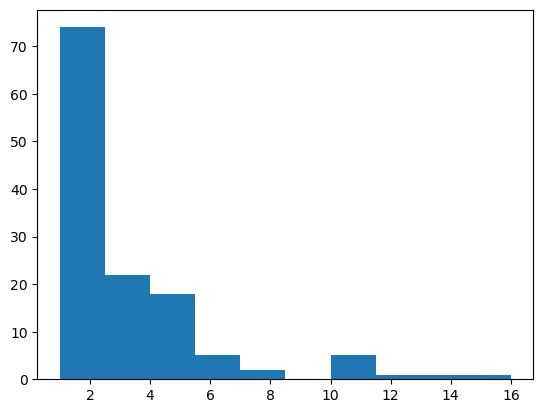

In [824]:
plt.hist(all_days)

### Set up dictionary to save data by day

In [825]:
across = {}

#========
lmax = 9
#========


cats = ['Fi=0', 'Xlim', 'Xp', 'Xo', 'seq', 'Ta', 'Vi', 'ws']

across[f'-1'] = {}
for cat in cats:
    across[f'-1'][cat] = np.array([])

for ll in range(1, lmax+1):
    across[f'{ll}'] = {}
    for cat in cats:
        across[f'{ll}'][cat] = np.array([])

across[f'{lmax+1}+'] = {}
for cat in cats:
    across[f'{lmax+1}+'][cat] = np.array([])
    
    
    
    
# model params
#===============================
wf = 0.02 # wind factor
ta = 35   # CW turning angle wind to ice, degrees
poly_dir = 145  #  polynya direction, degrees CCW from E
Hi = 25 * units('cm')
#===============================
    
for ev in list(evaluate.keys()):
    
    # open data from event
    dbi = evaluate[ev]['dbi']
    si = evaluate[ev]['si']
    fi = evaluate[ev]['fi']

    # grab conditions over event
    #===============================
    event_df = DF[dbi:fi+1]
    #===============================

    # run model
    X_num, X_max, t95, X_zip, Tair, Vice, wsp = Pease_Model_v2(event_df, wf=wf, ta=ta, poly_dir=poly_dir, Hi = Hi, show_plot = False)
    
    # save output
    for ll, Xp, Xm, Xz, Xo, Ta, Vi, ws in zip(event_df.event_day.values, X_num, X_max, X_zip, event_df.length_145max.values,
                                   Tair, Vice, wsp):

        # determine key to save to
        if ll == -999:
            key = '-1'
        elif ll > lmax:
            key = f'{lmax+1}+'
        else:
            key = f'{ll}'

        across[key]['Fi=0'] = np.append(across[key]['Fi=0'], Xz)
        across[key]['Xlim'] = np.append(across[key]['Xlim'], Xm)
        across[key]['Xp'] = np.append(across[key]['Xp'], Xp)
        across[key]['Xo'] = np.append(across[key]['Xo'], Xo*units('km'))
        
        across[key]['Ta'] = np.append(across[key]['Ta'], Ta)
        across[key]['Vi'] = np.append(across[key]['Vi'], Vi)
        across[key]['ws'] = np.append(across[key]['ws'], ws)
        
        # record sequence number
        across[key]['seq'] = np.append(across[key]['seq'], int(event_df.sequence.values[-1]))

In [826]:
list(set(across['10+']['seq']))

[32.0, 12.0, 140.0, 79.0, 82.0, 148.0, 85.0, 117.0]

In [827]:
DF.time[DF.sequence==117]

4847    2019-12-08
4848    2019-12-09
4849    2019-12-10
4850    2019-12-11
4851    2019-12-12
4852    2019-12-13
4853    2019-12-14
4854    2019-12-15
4855    2019-12-16
4856    2019-12-17
4857    2019-12-18
4858    2019-12-19
Name: time, dtype: object

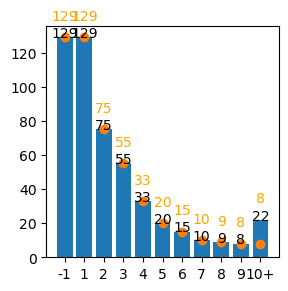

In [828]:
nums = np.array([len(across[ll]['Xlim']) for ll in across.keys()])
dnums = np.array([len(set(across[ll]['seq'])) for ll in across.keys()])

fig, ax = plt.subplots(figsize=(3,3))


ax.bar(across.keys(), nums)
ax.scatter(across.keys(), dnums)

for key, num, dnum in zip(across.keys(), nums, dnums):
    
    ax.text(key, num, num, ha='center')
    ax.text(key, num+10, dnum, ha='center', c='orange')

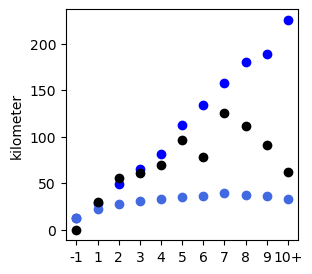

In [829]:
fig, ax = plt.subplots(figsize=(3,3))

for ll in across.keys():
    ax.scatter(ll, np.nanpercentile(across[ll]['Fi=0'], 50), c='b')
#     ax.scatter(ll, np.nanpercentile(across[ll]['Xlim'], 50), c='royalblue')
    ax.scatter(ll, np.nanpercentile(across[ll]['Xp'], 50), c='royalblue')
    
    ax.scatter(ll, np.nanpercentile(across[ll]['Xo'], 50), c='k')

### Grab percentiles over time

In [830]:
CATS = ['Fi=0', 'Xp', 'Xo', 'Xlim', 'Ta', 'ws', 'Vi']
percentiles = [5,25,50,75,95]
byday = {}

for cat in CATS:
    byday[cat] = {}
    for per in percentiles:
        byday[cat][per] = np.array([])
    

for cat in CATS:
    
    # grab all data
    all_data = np.array([])
    for ll in across.keys():
        all_data = np.append(all_data, across[ll][cat].magnitude)
        # save each percentile
        for per in percentiles:
            byday[cat][per] = np.append(byday[cat][per], np.nanpercentile(across[ll][cat], per))

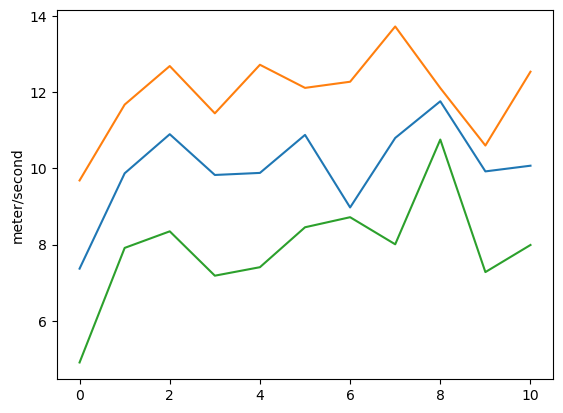

In [831]:
cat = 'ws'
plt.plot(byday[cat][50])
plt.plot(byday[cat][75])
plt.plot(byday[cat][25])

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_34950/2660563211.py:22: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Wind\nspeed\n($\mathrm{m\;s^{-1}}$)', rotation=0, labelpad=25, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_34950/2660563211.py:39: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mathrm{T_{a}\;(^{\circ}C)}$', rotation=0, labelpad=20, va='center')


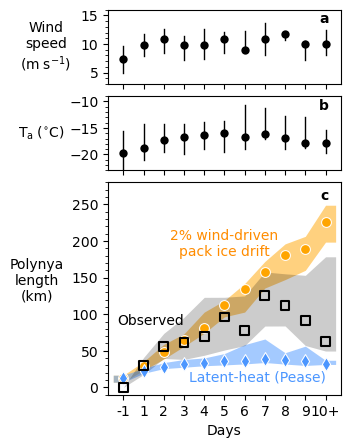

In [862]:
fig, axs = plt.subplots(3,1, figsize=(3,5), gridspec_kw={'height_ratios':[0.35,0.35,1]})
    

# for xx, cat, color, color2, fillc,lab, mr, zo, al, LW, S in zip([np.append(np.array([-1,0]),days), days, 
#                                         np.append(np.array([-1,0]),days),], ['wind', 'obs', 'lat'], 
#                               ['white', [0.3,0.3,0.3], 'white'][::-1], 
#                               [[75/255,150/255,255/255], 'None', 'orange'][::-1], 
#                                 [[75/255,150/255,255/255], 'k', 'orange'][::-1],                           
#                              ['Wind-driven ice drift', 'observed', 'Latent-heat estimate'],
#                                                ['d', 's', 'o'][::-1], [0,1,0], [0.4,0.15,0.4], [0.5,1.5,0.5],
#                                                           [60,40,60]):

x = np.arange(len(across.keys()))


ax = axs[0]
ax.set_xticks(x)
ax.set_xticklabels([])
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_ylim(3,16)
ax.set_ylabel('Wind\nspeed\n($\mathrm{m\;s^{-1}}$)', rotation=0, labelpad=25, va='center')
cat = 'ws'

for X, Ymin, Ymax in zip(x, byday[cat][25].magnitude, byday[cat][75].magnitude):
    ax.plot([X,X], [Ymin, Ymax], lw=1, color='k', alpha=1, zorder=-10)
ax.scatter(x, byday[cat][50], lw=0, color='k', alpha=1, zorder=-10)

# ax.fill_between(x, byday[cat][25], byday[cat][75], lw=0, color=fillc, alpha=alpha, zorder=-10)



ax = axs[1]
ax.set_xticks(x)
ax.set_xticklabels([])
ax.set_ylim(-23,-9)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_ylabel('$\mathrm{T_{a}\;(^{\circ}C)}$', rotation=0, labelpad=20, va='center')
cat = 'Ta'
for X, Ymin, Ymax in zip(x, byday[cat][25].magnitude, byday[cat][75].magnitude):
    ax.plot([X,X], [Ymin, Ymax], lw=1, color='k', alpha=1, zorder=-10)
ax.scatter(x, byday[cat][50], lw=0, color='k', alpha=1, zorder=-10)

ax = axs[2]

x_adj = np.concatenate((np.array([x.min()-0.5]), x, np.array([x.max()+0.5])))

for cat, fillc, alpha, edgec, facec, xx, LW, mr, ms in zip(['Fi=0', 'Xp', 'Xo'], 
                                      ['orange', [75/255,150/255,255/255], 'k'], 
                                                  [0.5,0.5,0.2],
                                     ['white', 'white', 'k'], 
                                                       
                                            ['orange', [75/255,150/255,255/255], 'None'], 
                                      [x_adj,x_adj,x_adj], 
                                                       [0.75,0.75,1.5],
                                     [ 'o','d', 's'], [50,50,40]):

    ax.fill_between(xx, np.concatenate((np.array([byday[cat][25][0].magnitude]), byday[cat][25].magnitude, np.array([byday[cat][25].magnitude[-1]]))), 
                   np.concatenate((np.array([byday[cat][75][0].magnitude]), byday[cat][75].magnitude, np.array([byday[cat][75].magnitude[-1]]))), lw=0, color=fillc, alpha=alpha, zorder=-10)
#     ax.fill_between(xx, byday[cat][5], byday[cat][95], lw=0, color=fillc, alpha=alpha, zorder=-10)
    
#     ax.fill_between(np.append(xx, xx[-1]+0.35), 
#                     np.append(byday[cat][25], byday[cat][25][-1]), 
#                     np.append(byday[cat][75], byday[cat][75][-1]), lw=0, color=fillc, alpha=al, zorder=-1)
    
    ax.scatter(xx[1:-1], byday[cat][50], 
               edgecolor=edgec, lw=LW,
               facecolor = facec,marker=mr, s=ms)
    
    
    
    
# plt.legend()
#     for dd in days:
#         yy = grouplen[cat]['all'][dd]
#         ax.scatter(np.full(len(yy), dd), yy, c=color2, s=1, zorder=-1)


ax.set_xticks(x)
ax.set_xticklabels(across.keys())

# ax.bar(days, nums/2, bottom=250, color='k', clip_on=False)
# for dd, n in zip(days, nums):
#     ax.text(dd, 250+n/2, f'{n:.0f}', c='k', ha='center', va='bottom', clip_on=False)

ax.set_ylim(-10,280)
ax.set_ylabel('Polynya\nlength\n(km)\n', rotation=0, labelpad=25, va='center')
ax.set_xlabel('Days')


ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))

for ax, ch in zip(axs, ['a', 'b', 'c']):
    ax.text(0.95,0.97, ch, weight='bold',  ha='right', va='top', transform=ax.transAxes)

# plt.axhline(6.25, zorder=-1, ls='dashed', c='darkgray')

plt.text(5, 180, '2% wind-driven\npack ice drift', ha='center', c='darkorange')
plt.text(3, 85, 'Observed', ha='right', c='k')
plt.text(10, 9, 'Latent-heat (Pease)', ha='right', c=[75/255,150/255,255/255])

for ax in axs:
    ax.set_xlim(-0.75,10.75)
# plt.axhline(6.25, c='darkgray', ls='dashed')
# plt.text(10, -5, 'SIC resolution', ha='right', c='gray')


plt.subplots_adjust(hspace=0.1)